## Libraries

In [1]:
import numpy as np
import pandas as pd

# Import the sk learn modules to segment
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
# Import pickle in order to be able to load  pickled objects.
import pickle

## Data Preparation

In [2]:
#load data
df_purchase = pd.read_csv('purchase data.csv')

# Import Scaler
scaler = pickle.load(open('scaler.pickle', 'rb'))
# Import PCA
pca = pickle.load(open('pca.pickle', 'rb'))
# Import K-Means
kmeans_pca = pickle.load(open('kmeans_pca.pickle', 'rb'))
# Standardization
features = df_purchase[['Sex', 'Marital status', 'Age', 'Education', 'Income', 'Occupation', 'Settlement size']]
df_purchase_segm_std = scaler.transform(features)
# Apply PCA
df_purchase_segm_pca = pca.transform(df_purchase_segm_std)
# Segment data
purchase_segm_kmeans_pca = kmeans_pca.predict(df_purchase_segm_pca)

# Create a copy of the data frame
df_purchase_predictors = df_purchase.copy()
# Add segment labels
df_purchase_predictors['Segment'] = purchase_segm_kmeans_pca
segment_dummies = pd.get_dummies(purchase_segm_kmeans_pca, prefix = 'Segment', prefix_sep = '_')
df_purchase_predictors = pd.concat([df_purchase_predictors, segment_dummies], axis = 1)

df_pa = df_purchase_predictors

## Purchase Probability Model


In [3]:
# In order to predict, need input and output variables. 
# Y is Incidence, as I want to predict the purchase probability for customers
Y = df_pa['Incidence']

In [4]:
# Dependant variable is based on the average price of chocolate candy bars. 
# Therefore, X is a data frame, containing the mean across the five prices.
X = pd.DataFrame()
X['Mean_Price'] = (df_pa['Price_1'] +
                   df_pa['Price_2'] +
                   df_pa['Price_3'] +
                   df_pa['Price_4'] +
                   df_pa['Price_5'] ) / 5

In [5]:
# We import the Logistic Regression module from sk learn for the purchase probability model.
from sklearn.linear_model import LogisticRegression 

In [6]:
# Create a Logistic Regression model using sk learn. Then fit the model with (X or price) and (Y or incidence).
model_purchase = LogisticRegression(solver = 'sag')
model_purchase.fit(X, Y)

LogisticRegression(solver='sag')

In [7]:
# The coefficients for price. It is negative, signaling that with an increase in price, the purchase probability decreases.
model_purchase.coef_

array([[-2.34781508]])

## Price Elasticity of Purchase Probability

In [8]:
# Here I see the prices for the five different brands, which is an important factor in determining purchase probability. 
# It informs the price range, for which I will be exploring purchase probability.
df_pa[['Price_1', 'Price_2', 'Price_3', 'Price_4', 'Price_5']].describe()

,Price_1,Price_2,Price_3,Price_4,Price_5
count,58693.000000,58693.000000,58693.000000,58693.000000,58693.000000
mean,1.392074,1.780999,2.006789,2.159945,2.654798
std,0.091139,0.170868,0.046867,0.089825,0.098272
min,1.100000,1.260000,1.870000,1.760000,2.110000
25%,1.340000,1.580000,1.970000,2.120000,2.630000
50%,1.390000,1.880000,2.010000,2.170000,2.670000
75%,1.470000,1.890000,2.060000,2.240000,2.700000
max,1.590000,1.900000,2.140000,2.260000,2.800000


In [9]:
# Introduce the price range for which we'll examine the purchase probability.
# Choose a price range between 0.5 and 3.49, which somewhat expands the actual observed price range, 
# which is from 1.1 to 2.8. 
price_range = np.arange(0.5, 3.5, 0.01)
price_range

array([0.5 , 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6 ,
       0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7 , 0.71,
       0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8 , 0.81, 0.82,
       0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9 , 0.91, 0.92, 0.93,
       0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.  , 1.01, 1.02, 1.03, 1.04,
       1.05, 1.06, 1.07, 1.08, 1.09, 1.1 , 1.11, 1.12, 1.13, 1.14, 1.15,
       1.16, 1.17, 1.18, 1.19, 1.2 , 1.21, 1.22, 1.23, 1.24, 1.25, 1.26,
       1.27, 1.28, 1.29, 1.3 , 1.31, 1.32, 1.33, 1.34, 1.35, 1.36, 1.37,
       1.38, 1.39, 1.4 , 1.41, 1.42, 1.43, 1.44, 1.45, 1.46, 1.47, 1.48,
       1.49, 1.5 , 1.51, 1.52, 1.53, 1.54, 1.55, 1.56, 1.57, 1.58, 1.59,
       1.6 , 1.61, 1.62, 1.63, 1.64, 1.65, 1.66, 1.67, 1.68, 1.69, 1.7 ,
       1.71, 1.72, 1.73, 1.74, 1.75, 1.76, 1.77, 1.78, 1.79, 1.8 , 1.81,
       1.82, 1.83, 1.84, 1.85, 1.86, 1.87, 1.88, 1.89, 1.9 , 1.91, 1.92,
       1.93, 1.94, 1.95, 1.96, 1.97, 1.98, 1.99, 2.

In [10]:
df_price_range = pd.DataFrame(price_range)

In [11]:
# Predict the purchase probability for this newly defined price range. 
# The result is a 2x300  array. The first column shows the probability for not purchasing the product, 
# the second the probability for purchase for each price point in our price range.
Y_pr = model_purchase.predict_proba(df_price_range)
purchase_pr = Y_pr[:][:, 1]
pe = model_purchase.coef_[:, 0] * price_range * (1 - purchase_pr)

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [12]:
# Create price elasticities master data frame.
# It will contain all the elasticities I calculate during the purchase analytics.
df_price_elasticities = pd.DataFrame(price_range)

In [13]:
df_price_elasticities = df_price_elasticities.rename(columns = {0: "Price_Point"})
df_price_elasticities['Mean_PE'] = pe
df_price_elasticities

,Price_Point,Mean_PE
0,0.50,-0.096346
1,0.51,-0.100412
2,0.52,-0.104605
3,0.53,-0.108927
4,0.54,-0.113383
...,...,...
295,3.45,-8.011979
296,3.46,-8.037228
297,3.47,-8.062442
298,3.48,-8.087623


In [14]:
pd.options.display.max_rows = None
df_price_elasticities

,Price_Point,Mean_PE
0,0.50,-0.096346
1,0.51,-0.100412
2,0.52,-0.104605
3,0.53,-0.108927
4,0.54,-0.113383
5,0.55,-0.117976
6,0.56,-0.122708
7,0.57,-0.127583
8,0.58,-0.132605
9,0.59,-0.137777


In [15]:
#Import the necessary libraries for visualization. Set seaborn do be our default.
import matplotlib.pyplot as plt
import matplotlib.axes as axs
import seaborn as sns
sns.set()

Text(0.5, 1.0, 'Price Elasticity of Purchase Probability')

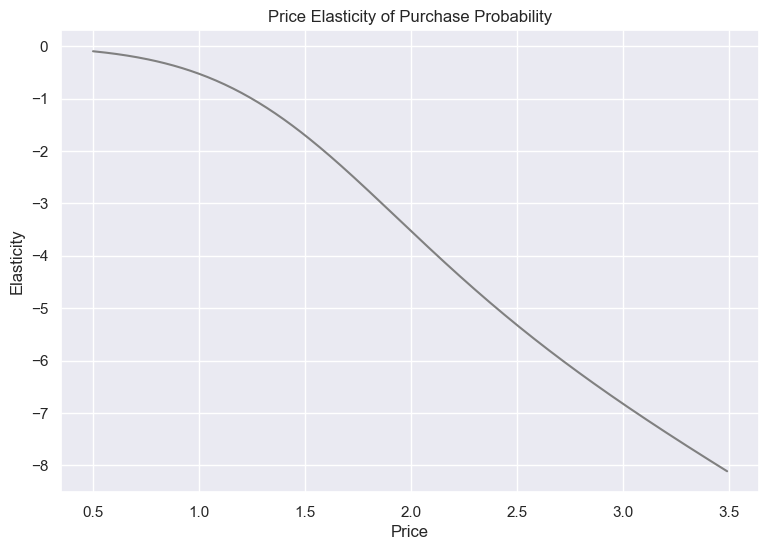

In [16]:
# Display the price elasticity of purchase probability of the average customer.
# observe that the price elasticities are all negative. Furthermore I can spot where the customer becomes inelastic.
# But to find the precise spot I can consult the price elasticities data frame.
plt.figure(figsize = (9, 6))
plt.plot(price_range, pe, color = 'grey')
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Purchase Probability')

## Purchase Probability by Segments


### $\color{green}{\text{Segment 1 - Career-Focused}}$

In [17]:
# Filter the data to contain only customers from segment 1, the career-focused.
df_pa_segment_1 = df_pa[df_pa['Segment'] == 1]

In [18]:
# To predict the purchase probability, so  Y variable is the incidence column.
# Only here I select only the customers from the first segment.
Y = df_pa_segment_1['Incidence']

In [19]:
X = pd.DataFrame()

In [20]:
# Calculate the average price for purchases in segment 1. Dependant variable contains the mean price of the brands.
X['Mean_Price'] = (df_pa_segment_1['Price_1'] + 
                   df_pa_segment_1['Price_2'] + 
                   df_pa_segment_1['Price_3'] + 
                   df_pa_segment_1['Price_4'] + 
                   df_pa_segment_1['Price_5']) / 5

In [21]:
# Fit logistic regression model
model_incidence_segment_1 = LogisticRegression(solver = 'sag')
model_incidence_segment_1.fit(X, Y)

LogisticRegression(solver='sag')

In [22]:
# You observe that the price coefficient for the career focused is -1.7, whereas for the average customer it was -2.35.
# This is an indicator, that this segment is less price sensitive compared to the average customer.
model_incidence_segment_1.coef_

array([[-1.71130633]])

In [23]:
# Calculate Price Elasticity of the career-focused segment.
Y_segment_1 = model_incidence_segment_1.predict_proba(df_price_range)
purchase_pr_segment_1 = Y_segment_1[:][:, 1]
pe_segment_1 = model_incidence_segment_1.coef_[:, 0] * price_range * (1 - purchase_pr_segment_1)

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


### Results

In [24]:
df_price_elasticities['PE_Segment_1'] = pe_segment_1

Text(0.5, 1.0, 'Price Elasticity of Purchase Probability')

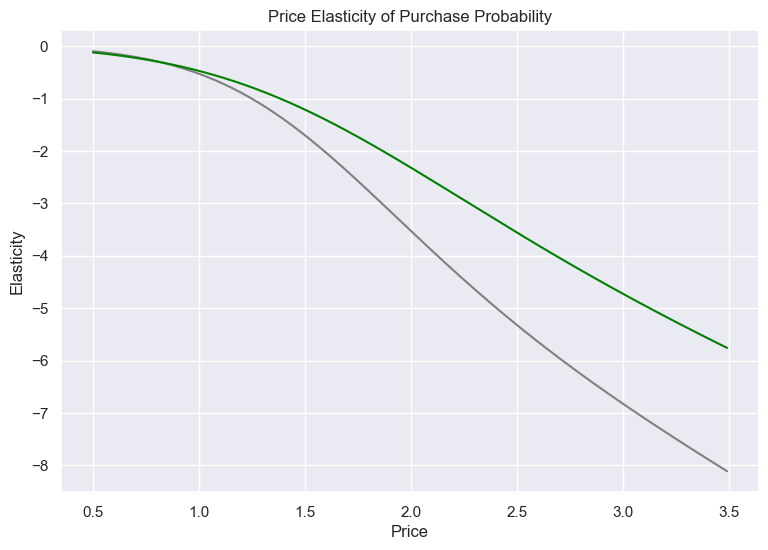

In [25]:
# Plot the elasticities of the average customer and the career-focused segment side by side. 
# The career-focused segment is displayed in green. The same color I used during the descriptive analysis.
plt.figure(figsize = (9, 6))
plt.plot(price_range, pe, color = 'grey')
plt.plot(price_range, pe_segment_1, color = 'green')
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Purchase Probability')

### $\color{red}{\text{Segment 2 - Fewer-Opportunities}}$

In [26]:
# Select only customers from segment 2, the fewer-opportunities.
df_pa_segment_2 = df_pa[df_pa['Segment'] == 2]

In [27]:
# Logistic regression model
Y = df_pa_segment_2['Incidence']

X = pd.DataFrame()
# Calculate average price for this segment
X['Mean_Price'] = (df_pa_segment_2['Price_1'] + 
                   df_pa_segment_2['Price_2'] + 
                   df_pa_segment_2['Price_3'] + 
                   df_pa_segment_2['Price_4'] + 
                   df_pa_segment_2['Price_5']) / 5

model_incidence_segment2 = LogisticRegression(solver = 'sag')
model_incidence_segment2.fit(X, Y)

# Calculate price elasticities
model_incidence_segment2.coef_
Y_segment_2 = model_incidence_segment2.predict_proba(df_price_range)
purchase_pr_segment2 = Y_segment_2[:][: , 1]
pe_segment2 = model_incidence_segment2.coef_[:,0] * price_range * ( 1- purchase_pr_segment2)

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


### Results

In [28]:
df_price_elasticities['PE_Segment_2'] = pe_segment2

Text(0.5, 1.0, 'Price Elasticity of Purchase Probability')

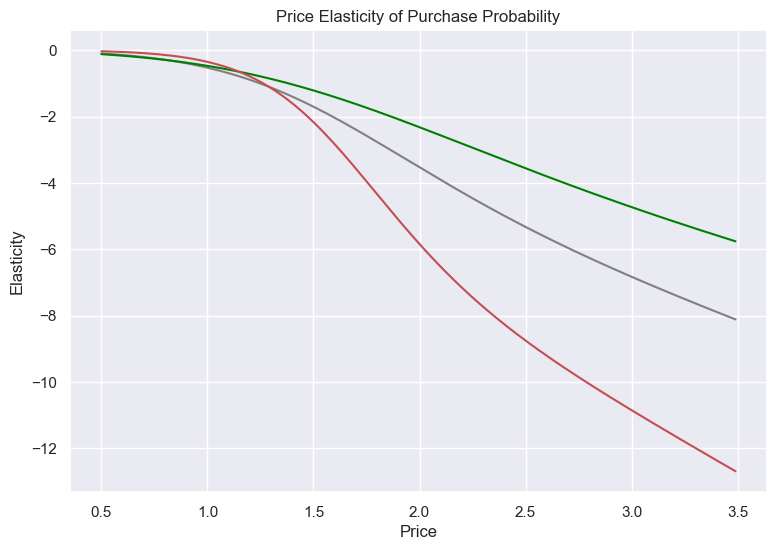

In [29]:
plt.figure(figsize = (9, 6))
plt.plot(price_range, pe, color = 'grey')
plt.plot(price_range, pe_segment_1, color = 'green')
plt.plot(price_range, pe_segment2, color = 'r')
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Purchase Probability')

### $\color{blue}{\text{Segment 0 - Standard}}$

In [30]:
# Select only customers from segment 0, the standard segment.
df_pa_segment_0 = df_pa[df_pa['Segment'] == 0]
# Prepare dependant and independant variables.
Y = df_pa_segment_0['Incidence']

X = pd.DataFrame()
# Calculate average price for this segment
X['Mean_Price'] = (df_pa_segment_0['Price_1'] + 
                   df_pa_segment_0['Price_2'] + 
                   df_pa_segment_0['Price_3'] + 
                   df_pa_segment_0['Price_4'] + 
                   df_pa_segment_0['Price_5']) / 5
# Logistic regression model
model_incidence_segment0 = LogisticRegression(solver = 'sag')
model_incidence_segment0.fit(X, Y)

model_incidence_segment0.coef_
Y_segment_0 = model_incidence_segment0.predict_proba(df_price_range)
purchase_pr_segment0 = Y_segment_0[:][: , 1]
pe_segment0 = model_incidence_segment0.coef_[:,0] * price_range *( 1- purchase_pr_segment0)
df_price_elasticities.insert(2, column = 'PE_Segment_0', value = pe_segment0)

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


### $\color{orange}{\text{Segment 3 - Well-Off}}$


In [31]:
# Select only customers from segment 3 
df_pa_segment_3 = df_pa[df_pa['Segment'] == 3]
# Prepare dependant and independant variables.
Y = df_pa_segment_3['Incidence']

X = pd.DataFrame()
# Calculate average price for this segment
X['Mean_Price'] = (df_pa_segment_3['Price_1'] + 
                   df_pa_segment_3['Price_2'] + 
                   df_pa_segment_3['Price_3'] + 
                   df_pa_segment_3['Price_4'] + 
                   df_pa_segment_3['Price_5']) / 5
# Logistic regression model
model_incidence_segment3 = LogisticRegression(solver = 'sag')
model_incidence_segment3.fit(X, Y)

model_incidence_segment3.coef_
Y_segment_3 = model_incidence_segment3.predict_proba(df_price_range)
purchase_pr_segment3 = Y_segment_3[:][: , 1]
pe_segment3 = model_incidence_segment3.coef_[:,0] * price_range *( 1- purchase_pr_segment3)
df_price_elasticities['PE_Segment_3'] = pe_segment3
df_price_elasticities

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


,Price_Point,Mean_PE,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3
0,0.50,-0.096346,-0.211223,-0.119071,-0.030916,-0.168003
1,0.51,-0.100412,-0.217794,-0.123252,-0.032682,-0.172927
2,0.52,-0.104605,-0.224472,-0.127527,-0.034536,-0.177921
3,0.53,-0.108927,-0.231260,-0.131897,-0.036480,-0.182985
4,0.54,-0.113383,-0.238156,-0.136363,-0.038519,-0.188121
5,0.55,-0.117976,-0.245163,-0.140926,-0.040657,-0.193329
6,0.56,-0.122708,-0.252280,-0.145589,-0.042899,-0.198610
7,0.57,-0.127583,-0.259509,-0.150352,-0.045248,-0.203963
8,0.58,-0.132605,-0.266850,-0.155218,-0.047710,-0.209389
9,0.59,-0.137777,-0.274304,-0.160187,-0.050289,-0.214888


### ${\textbf{Results}}$

Text(0.5, 1.0, 'Price Elasticity of Purchase Probability')

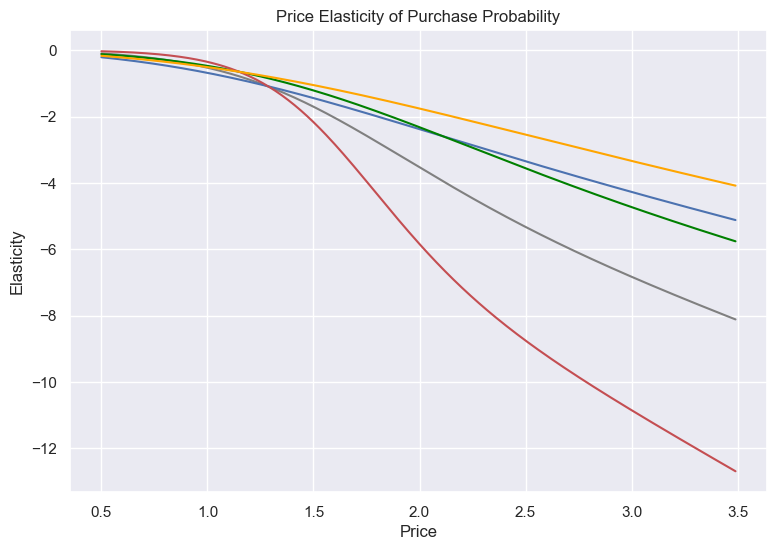

In [32]:
# Display all elasticities of purchase probability on the same plot. 
# Observe that the Career-focused segment are the least elastic when compared to the rest. 
# So, their purchase probability elasticity is not as affected by price.
# The price elasticities for the Standard segment seem to differ across price range. This may be due to the fact that
# the standard segment is least homogenous, which I discovered during this descriptive analysis. 
# It may be that the customers in this segment have different shopping habbits, which is why their 
# customers start with being more elastic than average but then shift to being more inelastic than the average customer
# and indeed the Career-focused segment.
plt.figure(figsize = (9, 6))
plt.plot(price_range, pe, color = 'grey')
plt.plot(price_range, pe_segment0, color = 'b')
plt.plot(price_range, pe_segment_1, color = 'green')
plt.plot(price_range, pe_segment2, color = 'r')
plt.plot(price_range, pe_segment3, color = 'orange')
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Purchase Probability')

## Purchase Probability with Promotion Feature

### Data Preparation

In [33]:
Y = df_pa['Incidence']

In [34]:
X = pd.DataFrame()
X['Mean_Price'] = (df_pa['Price_1'] + 
                   df_pa['Price_2'] + 
                   df_pa['Price_3'] + 
                   df_pa['Price_4'] + 
                   df_pa['Price_5']) / 5

In [35]:
# Include a second promotion feature. I'd like to examine the effects of promotions on purchase probability.
# Calculate the average promotion rate across the five brands. So I add the mean price for the brands.
X['Mean_Promotion'] = (df_pa['Promotion_1'] +
                       df_pa['Promotion_2'] +
                       df_pa['Promotion_3'] +
                       df_pa['Promotion_4'] +
                       df_pa['Promotion_5'] ) / 5
X.head()

,Mean_Price,Mean_Promotion
0,2.044,0.2
1,2.028,0.0
2,2.028,0.0
3,2.028,0.0
4,2.030,0.0


## Model Estimation

In [36]:
# The coefficient for promotion is positive. 
# Therefore, there is a positive relationship between promotion and purchase probability.
model_incidence_promotion = LogisticRegression(solver = 'sag')
model_incidence_promotion.fit(X, Y)
model_incidence_promotion.coef_

array([[-1.4939659 ,  0.56149957]])

## Price Elasticity with Promotion

In [37]:
# Create a data frame on which this model will predict. I need to include A price and promotion feature.
# First, I'll include the price range as the price feature. Next, I'll include the promotion feature.
df_price_elasticity_promotion = pd.DataFrame(price_range)
df_price_elasticity_promotion = df_price_elasticity_promotion.rename(columns = {0: "Price_Range"})

In [38]:
# I'll calculate price elasticities of purchase probability when I assume there is a promotion across at each price points.
df_price_elasticity_promotion['Promotion'] = 1

In [39]:
# Purchase Probability with Promotion Model Prediction
#Y_promotion = model_incidence_promotion.predict_proba(df_price_elasticity_promotion)

In [40]:
#promo = Y_promotion[:, 1]
#price_elasticity_promo = (model_incidence_promotion.coef_[:, 0] * price_range) * (1 - promo)

In [41]:
# Update master data to include elasticities of purchase probability with promotion feature
#df_price_elasticities['Elasticity_Promotion_1'] = price_elasticity_promo
#df_price_elasticities

## Price Elasticity without Promotion

In [42]:
df_price_elasticity_promotion_no = pd.DataFrame(price_range)
df_price_elasticity_promotion_no = df_price_elasticity_promotion_no.rename(columns = {0: "Price_Range"})

In [43]:
# Promotion feature -No Promotion.
# Assume there aren't any promotional activities on any of the price points.
# Examine the elasticity of purchase probability when there isn't promotion.
df_price_elasticity_promotion_no['Promotion'] = 0

In [44]:
#Purchase Probability without Promotion Model Prediction
#Y_no_promo = model_incidence_promotion.predict_proba(df_price_elasticity_promotion_no)

In [45]:
#no_promo = Y_no_promo[: , 1]

In [46]:
#price_elasticity_no_promo = model_incidence_promotion.coef_[:, 0] * price_range *(1- no_promo)

In [47]:
# Update master data frame to include purchase probability elasticities without promotion.
# You can now see the values with and without promotion and compare them for each price point in our price range.
#df_price_elasticities['Elasticity_Promotion_0'] = price_elasticity_no_promo

In [48]:
# Plot purchase elasticities with and without promotion side by side for comprarisson.
#plt.figure(figsize = (9, 6))
#plt.plot(price_range, price_elasticity_no_promo)
#plt.plot(price_range, price_elasticity_promo)
#plt.xlabel('Price')
#plt.ylabel('Elasticity')
#plt.title('Price Elasticity of Purchase Probability with and without Promotion')

## ${\textbf{Brand Choice}}$

### Data Preparation

In [49]:
# Here I am interested in determining the brand choice of the customer. 
# Hence, I filter our data, to include only purchase occasion, when a purchase has occured. 
brand_choice = df_pa[df_pa['Incidence'] == 1]

In [50]:
# I cap the maximum displayed rows in a table, to make computation more efficient and easier readability.
pd.options.display.max_rows = 100
brand_choice

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,...,Age,Education,Income,Occupation,Settlement size,Segment,Segment_0,Segment_1,Segment_2,Segment_3
6,200000001,28,1,2,2,0,0,1.50,1.90,1.99,...,47,1,110866,1,0,2,0,0,1,0
11,200000001,58,1,5,1,0,0,1.39,1.90,1.91,...,47,1,110866,1,0,2,0,0,1,0
19,200000001,110,1,1,2,0,0,1.47,1.90,1.99,...,47,1,110866,1,0,2,0,0,1,0
24,200000001,142,1,4,1,0,0,1.21,1.35,1.99,...,47,1,110866,1,0,2,0,0,1,0
29,200000001,183,1,2,3,0,0,1.46,1.88,1.97,...,47,1,110866,1,0,2,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58621,200000500,296,1,2,6,0,0,1.48,1.89,2.01,...,42,1,120946,1,0,2,0,0,1,0
58648,200000500,460,1,1,12,0,0,1.35,1.57,2.02,...,42,1,120946,1,0,2,0,0,1,0
58674,200000500,641,1,2,7,0,0,1.50,1.85,2.06,...,42,1,120946,1,0,2,0,0,1,0
58687,200000500,697,1,2,6,0,0,1.42,1.51,1.97,...,42,1,120946,1,0,2,0,0,1,0


In [51]:
# The model will predict the brand.
Y = brand_choice['Brand']

In [52]:
# Here I decide which features to include for prediction.
brand_choice.columns.values

array(['ID', 'Day', 'Incidence', 'Brand', 'Quantity', 'Last_Inc_Brand',
       'Last_Inc_Quantity', 'Price_1', 'Price_2', 'Price_3', 'Price_4',
       'Price_5', 'Promotion_1', 'Promotion_2', 'Promotion_3',
       'Promotion_4', 'Promotion_5', 'Sex', 'Marital status', 'Age',
       'Education', 'Income', 'Occupation', 'Settlement size', 'Segment',
       'Segment_0', 'Segment_1', 'Segment_2', 'Segment_3'], dtype=object)

In [53]:
# Predict based on the prices for the five brands.
features = ['Price_1', 'Price_2', 'Price_3', 'Price_4', 'Price_5']
X = brand_choice[features]

In [54]:
# Brand Choice Model fit.
model_brand_choice = LogisticRegression(solver = 'sag', multi_class = 'multinomial')
model_brand_choice.fit(X, Y)

LogisticRegression(multi_class='multinomial', solver='sag')

In [55]:
# Here are the coeffictients for the model. I have five brands and five features for the price. 
# Therefore, this output is somewhat difficult to read.
model_brand_choice.coef_

array([[-3.91596318,  0.65845696,  2.41769784,  0.70408052, -0.20211579],
       [ 1.27460986, -1.8798577 , -0.21265706, -0.20634318,  0.58786792],
       [ 1.62420234,  0.56212043,  0.50094477,  1.03951929,  0.45280284],
       [ 0.57453357,  0.39558447, -1.40062301, -1.24624695,  0.24934703],
       [ 0.44261742,  0.26369584, -1.30536254, -0.29100968, -1.087902  ]])

In [56]:
# I create a pandas data frame, which contains to coefficients.
bc_coef = pd.DataFrame(model_brand_choice.coef_)
bc_coef

,0,1,2,3,4
0,-3.915963,0.658457,2.417698,0.704081,-0.202116
1,1.274610,-1.879858,-0.212657,-0.206343,0.587868
2,1.624202,0.562120,0.500945,1.039519,0.452803
3,0.574534,0.395584,-1.400623,-1.246247,0.249347
4,0.442617,0.263696,-1.305363,-0.291010,-1.087902


In [57]:
# Make some transformations on the coefficients data frame to increase readability.
# Transpose the data frame, to keep with the conventional representation of results.
# Add labels for the columns and the index, which represent the coefficients of the brands and prices, respectively. 
bc_coef = pd.DataFrame(np.transpose(model_brand_choice.coef_))
coefficients = ['Coef_Brand_1', 'Coef_Brand_2', 'Coef_Brand_3', 'Coef_Brand_4', 'Coef_Brand_5']
bc_coef.columns = [coefficients]
prices = ['Price_1', 'Price_2', 'Price_3', 'Price_4', 'Price_5']
bc_coef.index = [prices]
bc_coef = bc_coef.round(2)
bc_coef

,Coef_Brand_1,Coef_Brand_2,Coef_Brand_3,Coef_Brand_4,Coef_Brand_5
Price_1,-3.92,1.27,1.62,0.57,0.44
Price_2,0.66,-1.88,0.56,0.40,0.26
Price_3,2.42,-0.21,0.50,-1.40,-1.31
Price_4,0.70,-0.21,1.04,-1.25,-0.29
Price_5,-0.20,0.59,0.45,0.25,-1.09


## Own Price Elasticity Brand 5

In [58]:
# Calculate price elasticity of brand choice.
# Here Create a data frame with price columns, which this model will use to predict the brand choice probabilities.
df_own_brand_5 = pd.DataFrame(index = np.arange(price_range.size))
df_own_brand_5['Price_1'] = brand_choice['Price_1'].mean()
df_own_brand_5['Price_2'] = brand_choice['Price_2'].mean()
df_own_brand_5['Price_3'] = brand_choice['Price_3'].mean()
df_own_brand_5['Price_4'] = brand_choice['Price_4'].mean()
df_own_brand_5['Price_5'] = price_range
df_own_brand_5

,Price_1,Price_2,Price_3,Price_4,Price_5
0,1.384559,1.764717,2.006694,2.159658,0.50
1,1.384559,1.764717,2.006694,2.159658,0.51
2,1.384559,1.764717,2.006694,2.159658,0.52
3,1.384559,1.764717,2.006694,2.159658,0.53
4,1.384559,1.764717,2.006694,2.159658,0.54
...,...,...,...,...,...
295,1.384559,1.764717,2.006694,2.159658,3.45
296,1.384559,1.764717,2.006694,2.159658,3.46
297,1.384559,1.764717,2.006694,2.159658,3.47
298,1.384559,1.764717,2.006694,2.159658,3.48


In [59]:
# Brand Choice Model prediction.
predict_brand_5 = model_brand_choice.predict_proba(df_own_brand_5)

In [60]:
# This model returns the probabilities of choosing each of the 5 brands. 
# Since, I am interested in the probability for the fifth brand I need to obtain the last column located on position 4,
# as I was starting to count from 0.
pr_own_brand_5 = predict_brand_5[: ][:, 4]

In [61]:
# Choosing brand 5. 
# Therefore, the beta coefficient I require is that of the brand 5 coefficient and price 5.
beta5 = bc_coef.iloc[4, 4]
beta5

-1.09

In [62]:
# Calculating price elasticities for brand choice without promotion. 
own_price_elasticity_brand_5 = beta5 * price_range * (1 - pr_own_brand_5)

In [63]:
# Adding the price elasticities to our master data frame. 
df_price_elasticities['Brand_5'] = own_price_elasticity_brand_5
pd.options.display.max_rows = None
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3,Brand_5
0,0.50,-0.096346,-0.211223,-0.119071,-0.030916,-0.168003,-0.049055
1,0.51,-0.100412,-0.217794,-0.123252,-0.032682,-0.172927,-0.050616
2,0.52,-0.104605,-0.224472,-0.127527,-0.034536,-0.177921,-0.052207
3,0.53,-0.108927,-0.231260,-0.131897,-0.036480,-0.182985,-0.053827
4,0.54,-0.113383,-0.238156,-0.136363,-0.038519,-0.188121,-0.055477
5,0.55,-0.117976,-0.245163,-0.140926,-0.040657,-0.193329,-0.057158
6,0.56,-0.122708,-0.252280,-0.145589,-0.042899,-0.198610,-0.058871
7,0.57,-0.127583,-0.259509,-0.150352,-0.045248,-0.203963,-0.060615
8,0.58,-0.132605,-0.266850,-0.155218,-0.047710,-0.209389,-0.062391
9,0.59,-0.137777,-0.274304,-0.160187,-0.050289,-0.214888,-0.064200


Text(0.5, 1.0, 'Own Price Elasticity of Purchase Probability for Brand 5')

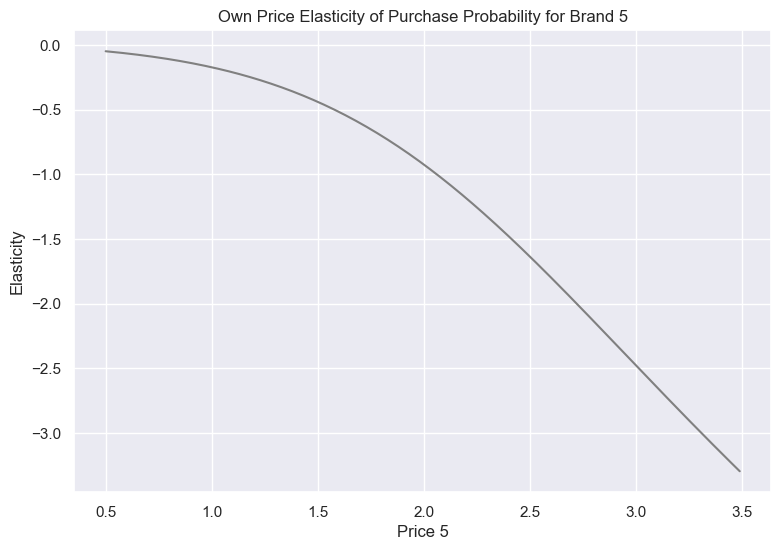

In [64]:
# Plot elasticities of purchase probability for brand 5.
plt.figure(figsize = (9, 6))
plt.plot(price_range, own_price_elasticity_brand_5, color = 'grey')
plt.xlabel('Price 5')
plt.ylabel('Elasticity')
plt.title('Own Price Elasticity of Purchase Probability for Brand 5')

## Cross Price Elasticity Brand 5, Cross Brand 4


In [65]:
# I want to examine the effect of the changes in price of a competitor brand.
# As I've discussed in the lecture, the brand which comes closest to this own brand is brand 4. 
# Therefore, I need to examine changes in the price of this brand.
# Keep in mind, I could examine the cross price elasticities for any of the remaining brands, 
# I just need to update this data frame accordingly to contain the respective brand.
df_brand5_cross_brand4 = pd.DataFrame(index = np.arange(price_range.size))
df_brand5_cross_brand4['Price_1'] = brand_choice['Price_1'].mean()
df_brand5_cross_brand4['Price_2'] = brand_choice['Price_2'].mean()
df_brand5_cross_brand4['Price_3'] = brand_choice['Price_3'].mean()
df_brand5_cross_brand4['Price_4'] = price_range
df_brand5_cross_brand4['Price_5'] = brand_choice['Price_5'].mean()

In [66]:
df_brand5_cross_brand4.head()

,Price_1,Price_2,Price_3,Price_4,Price_5
0,1.384559,1.764717,2.006694,0.50,2.654296
1,1.384559,1.764717,2.006694,0.51,2.654296
2,1.384559,1.764717,2.006694,0.52,2.654296
3,1.384559,1.764717,2.006694,0.53,2.654296
4,1.384559,1.764717,2.006694,0.54,2.654296


In [67]:
predict_brand5_cross_brand4 = model_brand_choice.predict_proba(df_brand5_cross_brand4)

In [68]:
# As now I was interested in what the probability of choosing the competitor brand is, 
# I need to select the purchase probability for brand 4, contained in the 4th column with index 3. 
pr_brand_4 = predict_brand5_cross_brand4[:][:, 3]

In [69]:
beta5

-1.09

In [70]:
# In order to calculate the cross brand price elasticity, I need to use the new formula I introduced in the lecture.
# The elasticity is equal to negative the price coefficient of the own brand multiplied by the price of the cross brand,
# further multiplied by the probability for choosing the cross brand.
brand5_cross_brand4_price_elasticity = -beta5 * price_range * pr_brand_4

In [71]:
# Update price elasticities data frame to include the cross price elasticities for brand 5 with respect to brand 4.
df_price_elasticities['Brand_5_Cross_Brand_4'] = brand5_cross_brand4_price_elasticity
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3,Brand_5,Brand_5_Cross_Brand_4
0,0.50,-0.096346,-0.211223,-0.119071,-0.030916,-0.168003,-0.049055,0.332011
1,0.51,-0.100412,-0.217794,-0.123252,-0.032682,-0.172927,-0.050616,0.337287
2,0.52,-0.104605,-0.224472,-0.127527,-0.034536,-0.177921,-0.052207,0.342507
3,0.53,-0.108927,-0.231260,-0.131897,-0.036480,-0.182985,-0.053827,0.347668
4,0.54,-0.113383,-0.238156,-0.136363,-0.038519,-0.188121,-0.055477,0.352773
5,0.55,-0.117976,-0.245163,-0.140926,-0.040657,-0.193329,-0.057158,0.357820
6,0.56,-0.122708,-0.252280,-0.145589,-0.042899,-0.198610,-0.058871,0.362809
7,0.57,-0.127583,-0.259509,-0.150352,-0.045248,-0.203963,-0.060615,0.367741
8,0.58,-0.132605,-0.266850,-0.155218,-0.047710,-0.209389,-0.062391,0.372614
9,0.59,-0.137777,-0.274304,-0.160187,-0.050289,-0.214888,-0.064200,0.377430


Text(0.5, 1.0, 'Cross Price Elasticity of Brand 5 wrt Brand 4')

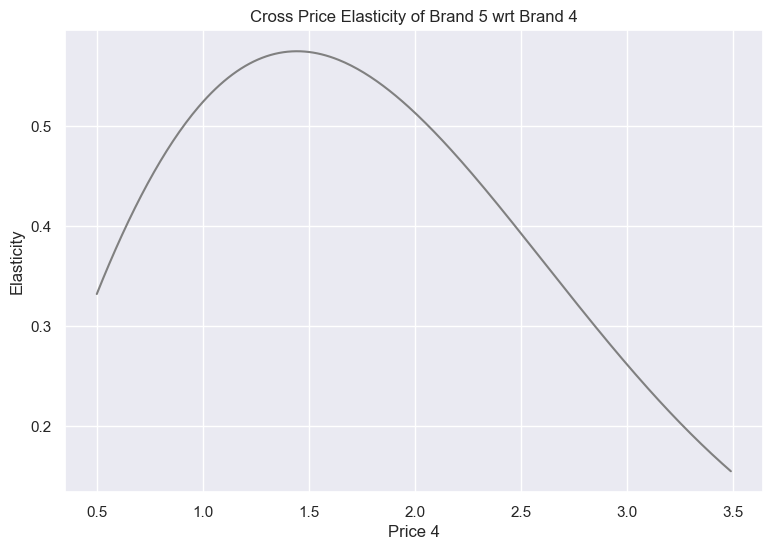

In [72]:
# Here I examine the cross price elasticity of purchase probability for brand 5 with respect to brand 4.
# I observe they are positive. As the price of the competitor brand increases, 
# so does the probability for purchasing this own brand.
# Even though the elasticity starts to decrease from the 1.45 mark, it is still positive, 
# signalling that the increase in purchase probability for the own brand happens more slowly.
plt.figure(figsize = (9, 6))
plt.plot(price_range, brand5_cross_brand4_price_elasticity, color = 'grey')
plt.xlabel('Price 4')
plt.ylabel('Elasticity')
plt.title('Cross Price Elasticity of Brand 5 wrt Brand 4')

## Own and Cross-Price Elasticity by Segment


### $\color{orange}{\text{Well-Off}}$

In [73]:
# I am interested in analysing the purchase probability for choosing brand 5 by segments.
# Filter our data to contain only purchase incidences of the third segment - Well-off.
brand_choice_s3 = df_pa[df_pa['Incidence'] == 1]
brand_choice_s3 = brand_choice_s3[brand_choice_s3['Segment'] == 3]

pd.options.display.max_rows = 100
brand_choice_s3

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,...,Age,Education,Income,Occupation,Settlement size,Segment,Segment_0,Segment_1,Segment_2,Segment_3
101,200000002,6,1,4,1,0,0,1.59,1.87,2.01,...,52,2,159052,2,1,3,0,0,0,1
115,200000002,100,1,4,2,0,0,1.47,1.90,1.95,...,52,2,159052,2,1,3,0,0,0,1
138,200000002,283,1,4,3,0,0,1.37,1.89,2.00,...,52,2,159052,2,1,3,0,0,0,1
141,200000002,307,1,4,1,0,0,1.34,1.89,2.01,...,52,2,159052,2,1,3,0,0,0,1
153,200000002,422,1,4,1,0,0,1.34,1.89,2.02,...,52,2,159052,2,1,3,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57346,200000489,687,1,4,1,4,1,1.50,1.87,2.06,...,44,2,193816,2,1,3,0,0,0,1
57347,200000489,693,1,4,2,4,1,1.42,1.51,2.02,...,44,2,193816,2,1,3,0,0,0,1
57348,200000489,701,1,4,3,4,1,1.42,1.85,1.99,...,44,2,193816,2,1,3,0,0,0,1
57350,200000489,715,1,4,2,0,0,1.50,1.80,2.09,...,44,2,193816,2,1,3,0,0,0,1


In [74]:
# Brand Choice Model estimation.
Y = brand_choice_s3['Brand']
brand_choice_s3 = pd.get_dummies(brand_choice_s3, columns=['Brand'], prefix = 'Brand', prefix_sep = '_')
X = brand_choice_s3[features]
model_brand_choice_s3 = LogisticRegression(solver = 'sag', multi_class = 'multinomial', max_iter = 300)
model_brand_choice_s3.fit(X, Y)

# Coefficients table for segment 3
bc_coef = pd.DataFrame(np.transpose(model_brand_choice_s3.coef_))
bc_coef.columns = [coefficients]
bc_coef.index = [prices]
bc_coef = bc_coef.round(2)
bc_coef

,Coef_Brand_1,Coef_Brand_2,Coef_Brand_3,Coef_Brand_4,Coef_Brand_5
Price_1,-2.15,1.33,0.82,0.12,-0.11
Price_2,-0.96,-1.38,1.29,0.78,0.27
Price_3,2.01,-1.65,-0.49,0.03,0.11
Price_4,2.52,0.96,-0.25,-1.90,-1.33
Price_5,-0.99,-0.30,1.17,0.56,-0.44


### $\color{orange}{\text{Own-Brand Price Elasticity}}$

In [75]:
# Calculating own-brand price elasticity for brand 5 and the Well-off segment.
df_own_brand_5_s3 = pd.DataFrame(index = np.arange(price_range.size))
df_own_brand_5_s3['Price_1'] = brand_choice_s3['Price_1'].mean()
df_own_brand_5_s3['Price_2'] = brand_choice_s3['Price_2'].mean()
df_own_brand_5_s3['Price_3'] = brand_choice_s3['Price_3'].mean()
df_own_brand_5_s3['Price_4'] = brand_choice_s3['Price_4'].mean()
df_own_brand_5_s3['Price_5'] = price_range

predict_own_brand_5_s3 = model_brand_choice_s3.predict_proba(df_own_brand_5_s3)
pr_own_brand_5_s3 = predict_own_brand_5_s3[: ][: , 4]

own_price_elasticity_brand_5_s3 =  beta5 * price_range * (1 - pr_own_brand_5_s3)
df_price_elasticities['Brand 5 S3'] = own_price_elasticity_brand_5_s3

### $\color{orange}{\text{Cross-Brand Price Elasticity}}$

In [76]:
# Calculating cross-brand price elasticity for brand 5 with respect to brand 4 for the Well-off segment.
df_brand5_cross_brand4_s3 = pd.DataFrame(index = np.arange(price_range.size))
df_brand5_cross_brand4_s3['Price_1'] = brand_choice_s3['Price_1'].mean()
df_brand5_cross_brand4_s3['Price_2'] = brand_choice_s3['Price_2'].mean()
df_brand5_cross_brand4_s3['Price_3'] = brand_choice_s3['Price_3'].mean()
df_brand5_cross_brand4_s3['Price_4'] = price_range
df_brand5_cross_brand4_s3['Price_5'] = brand_choice_s3['Price_5'].mean()

predict_brand5_cross_brand4_s3 = model_brand_choice_s3.predict_proba(df_brand5_cross_brand4_s3)
pr_cross_brand_5_s3 = predict_brand5_cross_brand4_s3[: ][: , 3]

# Update master data frame to include the newly obtained cross-brand price elasticities.
brand5_cross_brand4_price_elasticity_s3 = -beta5 * price_range * pr_cross_brand_5_s3
df_price_elasticities['Brand_5_Cross_Brand_4_S3'] = brand5_cross_brand4_price_elasticity_s3
pd.options.display.max_rows = None
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3,Brand_5,Brand_5_Cross_Brand_4,Brand 5 S3,Brand_5_Cross_Brand_4_S3
0,0.50,-0.096346,-0.211223,-0.119071,-0.030916,-0.168003,-0.049055,0.332011,-0.297342,0.482421
1,0.51,-0.100412,-0.217794,-0.123252,-0.032682,-0.172927,-0.050616,0.337287,-0.303389,0.491727
2,0.52,-0.104605,-0.224472,-0.127527,-0.034536,-0.177921,-0.052207,0.342507,-0.309445,0.501016
3,0.53,-0.108927,-0.231260,-0.131897,-0.036480,-0.182985,-0.053827,0.347668,-0.315513,0.510290
4,0.54,-0.113383,-0.238156,-0.136363,-0.038519,-0.188121,-0.055477,0.352773,-0.321591,0.519548
5,0.55,-0.117976,-0.245163,-0.140926,-0.040657,-0.193329,-0.057158,0.357820,-0.327681,0.528791
6,0.56,-0.122708,-0.252280,-0.145589,-0.042899,-0.198610,-0.058871,0.362809,-0.333782,0.538017
7,0.57,-0.127583,-0.259509,-0.150352,-0.045248,-0.203963,-0.060615,0.367741,-0.339896,0.547227
8,0.58,-0.132605,-0.266850,-0.155218,-0.047710,-0.209389,-0.062391,0.372614,-0.346022,0.556421
9,0.59,-0.137777,-0.274304,-0.160187,-0.050289,-0.214888,-0.064200,0.377430,-0.352162,0.565598


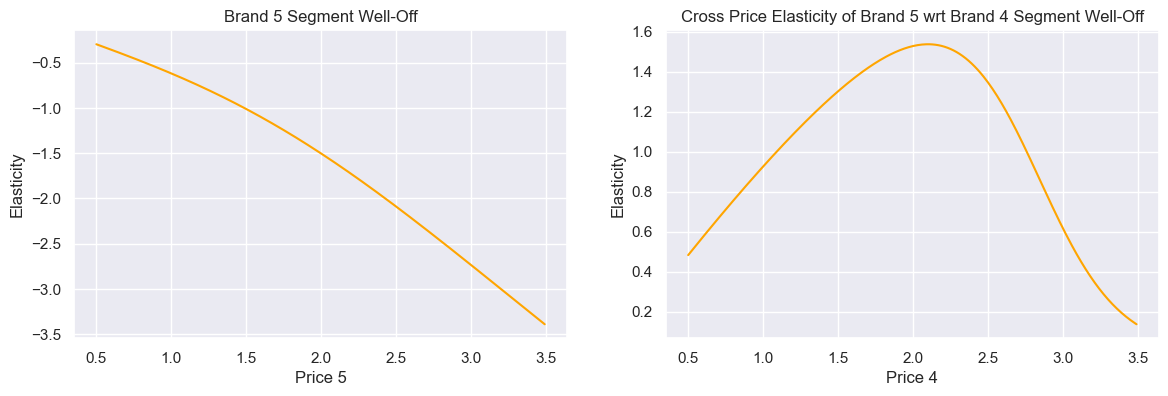

In [77]:
# Using a figure with axes we plot the own brand and cross-brand price elasticities for brand 5 cross brand 4 side by side.
fig, axs = plt.subplots(1, 2, figsize = (14, 4))
axs[0].plot(price_range, own_price_elasticity_brand_5_s3, color = 'orange')
axs[0].set_title('Brand 5 Segment Well-Off')
axs[0].set_xlabel('Price 5')

axs[1].plot(price_range, brand5_cross_brand4_price_elasticity_s3, color = 'orange')
axs[1].set_title('Cross Price Elasticity of Brand 5 wrt Brand 4 Segment Well-Off')
axs[1].set_xlabel('Price 4')

for ax in axs.flat:
    ax.set(ylabel = 'Elasticity')

### $\color{blue}{\text{Standard}}$


In [78]:
# Here I am interesting in analysing the brand choice probability of the Standard segment.
# Filter our data, by selecting only purchases from segment 0.
brand_choice_s0 = df_pa[df_pa['Incidence'] == 1]
brand_choice_s0 = brand_choice_s0[brand_choice_s0['Segment'] == 0]
brand_choice_s0.head()

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,...,Age,Education,Income,Occupation,Settlement size,Segment,Segment_0,Segment_1,Segment_2,Segment_3
2398,200000024,44,1,2,2,0,0,1.35,1.58,1.97,...,32,1,88428,0,0,0,1,0,0,0
2403,200000024,98,1,2,2,0,0,1.47,1.90,1.95,...,32,1,88428,0,0,0,1,0,0,0
2408,200000024,143,1,2,3,0,0,1.21,1.35,1.99,...,32,1,88428,0,0,0,1,0,0,0
2410,200000024,162,1,2,5,0,0,1.39,1.90,1.94,...,32,1,88428,0,0,0,1,0,0,0
2417,200000024,217,1,5,1,0,0,1.34,1.89,1.99,...,32,1,88428,0,0,0,1,0,0,0


In [79]:
# Brand Choice Model estimation.
Y = brand_choice_s0['Brand']
brand_choice_s0 = pd.get_dummies(brand_choice_s0, columns=['Brand'], prefix = 'Brand', prefix_sep = '_')
X = brand_choice_s0[features]
model_brand_choice_s0 = LogisticRegression(solver = 'sag', multi_class = 'multinomial', max_iter = 200)
model_brand_choice_s0.fit(X, Y)

# Coefficients table segment 0.
bc_coef = pd.DataFrame(np.transpose(model_brand_choice_s0.coef_))
bc_coef.columns = [coefficients]
bc_coef.index = [prices]
bc_coef = bc_coef.round(2)

### $\color{blue}{\text{Own-Brand Price Elasticity}}$

In [80]:
# Calculating own-brand price elasticity for brand 5 and the Standard segment.
df_own_brand_5_s0 = pd.DataFrame(index = np.arange(price_range.size))
df_own_brand_5_s0['Price_1'] = brand_choice_s0['Price_1'].mean()
df_own_brand_5_s0['Price_2'] = brand_choice_s0['Price_2'].mean()
df_own_brand_5_s0['Price_3'] = brand_choice_s0['Price_3'].mean()
df_own_brand_5_s0['Price_4'] = brand_choice_s0['Price_4'].mean()
df_own_brand_5_s0['Price_5'] = price_range

predict_own_brand_5_s0 = model_brand_choice_s0.predict_proba(df_own_brand_5_s0)
pr_own_brand_5_s0 = predict_own_brand_5_s0[: ][: , 4]

# Compute price elasticities and update master data frame.
# Include the elasticities for the segments in order from 0 to three, which is why we use insert() on position 10.
own_price_elasticity_brand_5_s0 =  beta5 * price_range * (1 - pr_own_brand_5_s0)
df_price_elasticities.insert(10, column = 'Brand 5 S0', value = own_price_elasticity_brand_5_s0)

### $\color{blue}{\text{Cross-Brand Price Elasticity}}$

In [81]:
# Calculating cross-brand price elasticity for brand 5 with respect to brand 4 for the Standard segment.
df_brand5_cross_brand4_s0 = pd.DataFrame(index = np.arange(price_range.size))
df_brand5_cross_brand4_s0['Price_1'] = brand_choice_s0['Price_1'].mean()
df_brand5_cross_brand4_s0['Price_2'] = brand_choice_s0['Price_2'].mean()
df_brand5_cross_brand4_s0['Price_3'] = brand_choice_s0['Price_3'].mean()
df_brand5_cross_brand4_s0['Price_4'] = price_range
df_brand5_cross_brand4_s0['Price_5'] = brand_choice_s0['Price_5'].mean()

predict_brand5_cross_brand4_s0 = model_brand_choice_s0.predict_proba(df_brand5_cross_brand4_s0)
pr_cross_brand_5_s0 = predict_brand5_cross_brand4_s0[: ][: , 3]

# Compute price elasticities and update master data frame.
# You need to use insert() on position 11, to save the price elasticities in the correct order.
brand5_cross_brand4_price_elasticity_s0 = -beta5 * price_range * pr_cross_brand_5_s0
df_price_elasticities.insert(11, column = 'Brand_5_Cross_Brand_4_S0', value = brand5_cross_brand4_price_elasticity_s0)

### $\color{green}{\text{Career-Focused}}$

In [82]:
# Filter data by the Career-focused segment, which is the first segment.
brand_choice_s1 = df_pa[df_pa['Incidence'] == 1]
brand_choice_s1 = brand_choice_s1[brand_choice_s1['Segment'] == 1]

In [83]:
# Brand Choice Model estimation.
Y = brand_choice_s1['Brand']
brand_choice_s1 = pd.get_dummies(brand_choice_s1, columns=['Brand'], prefix = 'Brand', prefix_sep = '_')
X = brand_choice_s1[features]
model_brand_choice_s1 = LogisticRegression(solver = 'sag', multi_class = 'multinomial', max_iter = 300)
model_brand_choice_s1.fit(X, Y)

# Coefficients table segment 1
bc_coef = pd.DataFrame(np.transpose(model_brand_choice_s1.coef_))
bc_coef.columns = [coefficients]
bc_coef.index = [prices]
bc_coef = bc_coef.round(2)

### $\color{green}{\text{Own-Brand Price Elasticity}}$

In [84]:
# Calculating own-brand price elasticity for brand 5 and the Career-focused segment.
df_own_brand_5_s1 = pd.DataFrame(index = np.arange(price_range.size))
df_own_brand_5_s1['Price_1'] = brand_choice_s1['Price_1'].mean()
df_own_brand_5_s1['Price_2'] = brand_choice_s1['Price_2'].mean()
df_own_brand_5_s1['Price_3'] = brand_choice_s1['Price_3'].mean()
df_own_brand_5_s1['Price_4'] = brand_choice_s1['Price_4'].mean()
df_own_brand_5_s1['Price_5'] = price_range

predict_own_brand_5_s1 = model_brand_choice_s1.predict_proba(df_own_brand_5_s1)
pr_own_brand_5_s1 = predict_own_brand_5_s1[: ][: , 4]

#compute price elasticities and update data frame
own_price_elasticity_brand_5_s1 =  beta5 * price_range * (1 - pr_own_brand_5_s1)
df_price_elasticities.insert(12, column = 'Brand 5 S1', value = own_price_elasticity_brand_5_s1)

### $\color{green}{\text{Cross-Brand Price Elasticity}}$

In [85]:
# Calculating cross-brand price elasticity for brand 5 with respect to brand 4 for the Career-focused segment.
df_brand5_cross_brand4_s1 = pd.DataFrame(index = np.arange(price_range.size))
df_brand5_cross_brand4_s1['Price_1'] = brand_choice_s1['Price_1'].mean()
df_brand5_cross_brand4_s1['Price_2'] = brand_choice_s1['Price_2'].mean()
df_brand5_cross_brand4_s1['Price_3'] = brand_choice_s1['Price_3'].mean()
df_brand5_cross_brand4_s1['Price_4'] = price_range
df_brand5_cross_brand4_s1['Price_5'] = brand_choice_s1['Price_5'].mean()

predict_brand5_cross_brand4_s1 = model_brand_choice_s1.predict_proba(df_brand5_cross_brand4_s1)
pr_cross_brand_5_s1 = predict_brand5_cross_brand4_s1[: ][: , 3]

brand5_cross_brand4_price_elasticity_s1 = -beta5 * price_range * pr_cross_brand_5_s1
df_price_elasticities.insert(13, column = 'Brand_5_Cross_Brand_4_S1', value = brand5_cross_brand4_price_elasticity_s1)

### $\color{red}{\text{Fewer-Opportunities}}$

In [86]:
# Filter data, select only purchases from segment 2, which is the Fewer-Opportunities segment.
brand_choice_s2 = df_pa[df_pa['Incidence'] == 1]
brand_choice_s2 = brand_choice_s2[brand_choice_s2['Segment'] == 2]

In [87]:
# Brand Choice Model estimation.
Y = brand_choice_s2['Brand']
brand_choice_s2 = pd.get_dummies(brand_choice_s2, columns=['Brand'], prefix = 'Brand', prefix_sep = '_')
X = brand_choice_s2[features]
model_brand_choice_s2 = LogisticRegression(solver = 'sag', multi_class = 'multinomial', max_iter = 300)
model_brand_choice_s2.fit(X, Y)

# Coefficients table segment 2
bc_coef = pd.DataFrame(np.transpose(model_brand_choice_s2.coef_))
bc_coef.columns = [coefficients]
bc_coef.index = [prices]
bc_coef = bc_coef.round(2)

### $\color{red}{\text{Own-Brand Price Elasticity}}$


In [88]:
# Calculating own-brand price elasticity for brand 5 and the Fewer-opportunities segment.
df_own_brand_5_s2 = pd.DataFrame(index = np.arange(price_range.size))
df_own_brand_5_s2['Price_1'] = brand_choice_s2['Price_1'].mean()
df_own_brand_5_s2['Price_2'] = brand_choice_s2['Price_2'].mean()
df_own_brand_5_s2['Price_3'] = brand_choice_s2['Price_3'].mean()
df_own_brand_5_s2['Price_4'] = brand_choice_s2['Price_4'].mean()
df_own_brand_5_s2['Price_5'] = price_range

predict_own_brand_5_s2 = model_brand_choice_s2.predict_proba(df_own_brand_5_s2)
pr_own_brand_5_s2 = predict_own_brand_5_s2[: ][: , 4]

#compute price elasticities and update data frame
own_price_elasticity_brand_5_s2 =  beta5 * price_range * (1 - pr_own_brand_5_s2)
df_price_elasticities.insert(14, column = 'Brand 5 S2', value = own_price_elasticity_brand_5_s2)

### $\color{red}{\text{Cross-Brand Price Elasticity}}$

In [89]:
# Calculating cross-brand price elasticity for brand 5 with respect to brand 4 for the Fewer-opportunities segment.
df_brand5_cross_brand4_s2 = pd.DataFrame(index = np.arange(price_range.size))
df_brand5_cross_brand4_s2['Price_1'] = brand_choice_s2['Price_1'].mean()
df_brand5_cross_brand4_s2['Price_2'] = brand_choice_s2['Price_2'].mean()
df_brand5_cross_brand4_s2['Price_3'] = brand_choice_s2['Price_3'].mean()
df_brand5_cross_brand4_s2['Price_4'] = price_range
df_brand5_cross_brand4_s2['Price_5'] = brand_choice_s2['Price_5'].mean()

predict_brand5_cross_brand4_s2 = model_brand_choice_s2.predict_proba(df_brand5_cross_brand4_s2)
pr_cross_brand_5_s2 = predict_brand5_cross_brand4_s2[: ][: , 3]

brand5_cross_brand4_price_elasticity_s2 = -beta5 * price_range * pr_cross_brand_5_s2
df_price_elasticities.insert(15, column = 'Brand_5_Cross_Brand_4_S2', value = brand5_cross_brand4_price_elasticity_s2)
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3,Brand_5,Brand_5_Cross_Brand_4,Brand 5 S3,Brand_5_Cross_Brand_4_S3,Brand 5 S0,Brand_5_Cross_Brand_4_S0,Brand 5 S1,Brand_5_Cross_Brand_4_S1,Brand 5 S2,Brand_5_Cross_Brand_4_S2
0,0.50,-0.096346,-0.211223,-0.119071,-0.030916,-0.168003,-0.049055,0.332011,-0.297342,0.482421,-0.115834,0.174120,-0.043941,0.194769,-0.001036,0.181595
1,0.51,-0.100412,-0.217794,-0.123252,-0.032682,-0.172927,-0.050616,0.337287,-0.303389,0.491727,-0.118873,0.176176,-0.045028,0.197253,-0.001098,0.183892
2,0.52,-0.104605,-0.224472,-0.127527,-0.034536,-0.177921,-0.052207,0.342507,-0.309445,0.501016,-0.121947,0.178180,-0.046124,0.199685,-0.001163,0.186141
3,0.53,-0.108927,-0.231260,-0.131897,-0.036480,-0.182985,-0.053827,0.347668,-0.315513,0.510290,-0.125056,0.180134,-0.047230,0.202068,-0.001231,0.188340
4,0.54,-0.113383,-0.238156,-0.136363,-0.038519,-0.188121,-0.055477,0.352773,-0.321591,0.519548,-0.128201,0.182037,-0.048345,0.204400,-0.001303,0.190491
5,0.55,-0.117976,-0.245163,-0.140926,-0.040657,-0.193329,-0.057158,0.357820,-0.327681,0.528791,-0.131382,0.183891,-0.049469,0.206682,-0.001378,0.192594
6,0.56,-0.122708,-0.252280,-0.145589,-0.042899,-0.198610,-0.058871,0.362809,-0.333782,0.538017,-0.134599,0.185694,-0.050603,0.208914,-0.001458,0.194648
7,0.57,-0.127583,-0.259509,-0.150352,-0.045248,-0.203963,-0.060615,0.367741,-0.339896,0.547227,-0.137854,0.187449,-0.051747,0.211098,-0.001541,0.196656
8,0.58,-0.132605,-0.266850,-0.155218,-0.047710,-0.209389,-0.062391,0.372614,-0.346022,0.556421,-0.141146,0.189154,-0.052900,0.213232,-0.001629,0.198615
9,0.59,-0.137777,-0.274304,-0.160187,-0.050289,-0.214888,-0.064200,0.377430,-0.352162,0.565598,-0.144475,0.190811,-0.054063,0.215317,-0.001722,0.200528


Text(0.5, 0, 'Price 4')

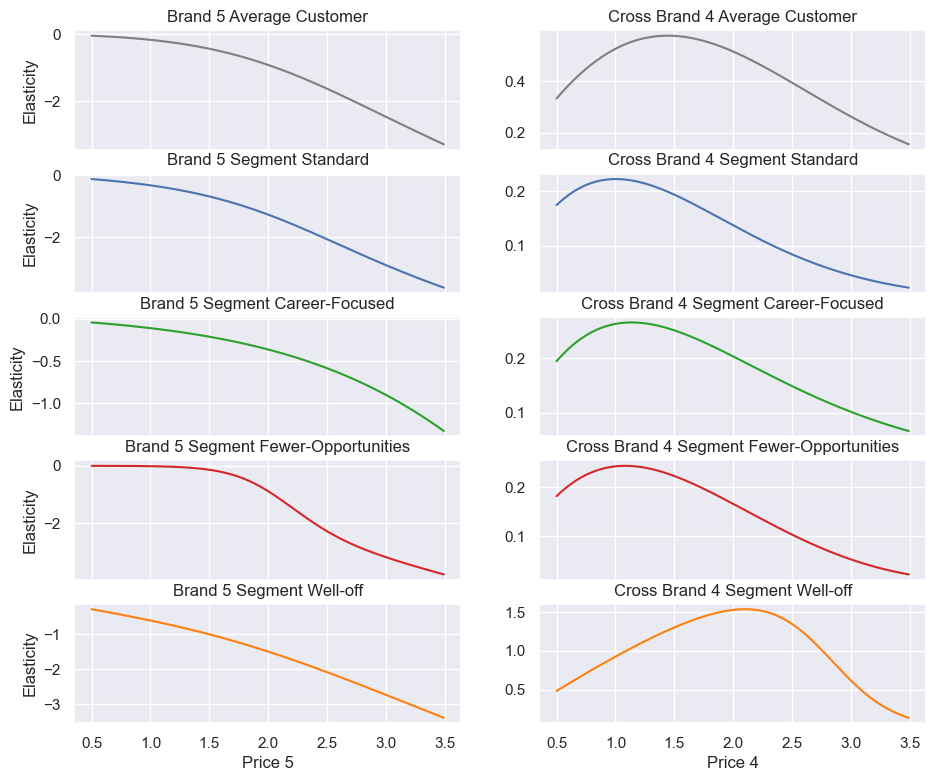

In [90]:
# Plot the own and cross brand price elasticities for the average customer and each of the four segments.
# You can observe differences and similiraties between the segments and examine their preference, when it comes to brand choice.
# The two segments, which seem to be of most interested for the marketing team of brand 5, seem to be the Career-focused
# and the Well-off. They are also the segments which purchase this brand most often. 
# The Career-focused segment is the most inelastic and they are the most loyal segment. 
# Based on our model, they do not seem to be that affected by price, therefore brand 5 could increase its price, 
# without fear of significant loss of customers from this segment. 
# The Well-off segment on the other hand, seems to be more elastic. They also purchase the competitor brand 4 most often.
# In order to target this segment, our analysis signals, that price needs to be decreased. However, keep in mind 
# that other factors aside from price might be influencing the purchase behaivour of this segment.
fig1, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 2, figsize = (11, 9), sharex = True)
ax1[0].plot(price_range, own_price_elasticity_brand_5, 'tab:grey')
ax1[0].set_title('Brand 5 Average Customer')
ax1[0].set_ylabel('Elasticity')
ax1[1].plot(price_range, brand5_cross_brand4_price_elasticity, 'tab:grey')
ax1[1].set_title('Cross Brand 4 Average Customer')


ax2[0].plot(price_range, own_price_elasticity_brand_5_s0)
ax2[0].set_title('Brand 5 Segment Standard')
ax2[0].set_ylabel('Elasticity')
ax2[1].plot(price_range, brand5_cross_brand4_price_elasticity_s0)
ax2[1].set_title('Cross Brand 4 Segment Standard')

ax3[0].plot(price_range, own_price_elasticity_brand_5_s1, 'tab:green')
ax3[0].set_title('Brand 5 Segment Career-Focused')
ax3[0].set_ylabel('Elasticity')
ax3[1].plot(price_range, brand5_cross_brand4_price_elasticity_s1, 'tab:green')
ax3[1].set_title('Cross Brand 4 Segment Career-Focused')

ax4[0].plot(price_range, own_price_elasticity_brand_5_s2, 'tab:red')
ax4[0].set_title('Brand 5 Segment Fewer-Opportunities')
ax4[0].set_ylabel('Elasticity')
ax4[1].plot(price_range, brand5_cross_brand4_price_elasticity_s2, 'tab:red')
ax4[1].set_title('Cross Brand 4 Segment Fewer-Opportunities')

ax5[0].plot(price_range, own_price_elasticity_brand_5_s3, 'tab:orange')
ax5[0].set_title('Brand 5 Segment Well-off')
ax5[0].set_xlabel('Price 5')
ax5[0].set_ylabel('Elasticity')
ax5[1].plot(price_range, brand5_cross_brand4_price_elasticity_s3, 'tab:orange')
ax5[1].set_title('Cross Brand 4 Segment Well-off')
ax5[1].set_xlabel('Price 4')

## Price Elasticity of Purchase Quantity

In [91]:
# I want to determine price elasticity of purchase quantity, also known as price elasticity of demand.
# I are interested in purchase ocassion, where the purchased quantity is different from 0.
# Therefore, once again I filter our data to contain only shopping visits where the client has purchased at least one product.
df_purchase_quantity = df_pa[df_pa['Incidence'] == 1]
df_purchase_quantity.head()

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,...,Age,Education,Income,Occupation,Settlement size,Segment,Segment_0,Segment_1,Segment_2,Segment_3
6,200000001,28,1,2,2,0,0,1.50,1.90,1.99,...,47,1,110866,1,0,2,0,0,1,0
11,200000001,58,1,5,1,0,0,1.39,1.90,1.91,...,47,1,110866,1,0,2,0,0,1,0
19,200000001,110,1,1,2,0,0,1.47,1.90,1.99,...,47,1,110866,1,0,2,0,0,1,0
24,200000001,142,1,4,1,0,0,1.21,1.35,1.99,...,47,1,110866,1,0,2,0,0,1,0
29,200000001,183,1,2,3,0,0,1.46,1.88,1.97,...,47,1,110866,1,0,2,0,0,1,0


In [92]:
# Create brand dummies, for each of the five brands.
df_purchase_quantity = pd.get_dummies(df_purchase_quantity, columns = ['Brand'], prefix = 'Brand', prefix_sep = '_')
# The descriptive analysis of the purchase quantitiy data frame, shows that quantity ranges from 1 to 15 
# and has an average value of 2.8, which means that more often than not our customers buy more than 1 chocolate candy bar.
df_purchase_quantity.describe()

,ID,Day,Incidence,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,Price_4,...,Segment,Segment_0,Segment_1,Segment_2,Segment_3,Brand_1,Brand_2,Brand_3,Brand_4,Brand_5
count,1.463800e+04,14638.000000,14638.0,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,...,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000
mean,2.000003e+08,359.607597,1.0,2.774559,1.535251,0.406955,1.384559,1.764717,2.006694,2.159658,...,1.581910,0.175229,0.299290,0.293824,0.231657,0.092226,0.310288,0.057453,0.199959,0.340074
std,1.423786e+02,205.346253,0.0,1.796736,2.060858,0.491283,0.090944,0.181667,0.046200,0.093253,...,1.028171,0.380176,0.457962,0.455528,0.421906,0.289354,0.462627,0.232714,0.399983,0.473750
min,2.000000e+08,1.000000,1.0,1.000000,0.000000,0.000000,1.100000,1.260000,1.870000,1.760000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000001e+08,175.000000,1.0,2.000000,0.000000,0.000000,1.340000,1.570000,1.970000,2.120000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000003e+08,355.000000,1.0,2.000000,0.000000,0.000000,1.390000,1.880000,2.010000,2.180000,...,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000004e+08,532.000000,1.0,3.000000,4.000000,1.000000,1.470000,1.890000,2.060000,2.240000,...,2.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,2.000005e+08,727.000000,1.0,15.000000,5.000000,1.000000,1.590000,1.900000,2.140000,2.260000,...,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [93]:
# Here I make a decission on which features to include in our model. I decide to include a Price and a Promotion feature.
df_purchase_quantity.columns.values

array(['ID', 'Day', 'Incidence', 'Quantity', 'Last_Inc_Brand',
       'Last_Inc_Quantity', 'Price_1', 'Price_2', 'Price_3', 'Price_4',
       'Price_5', 'Promotion_1', 'Promotion_2', 'Promotion_3',
       'Promotion_4', 'Promotion_5', 'Sex', 'Marital status', 'Age',
       'Education', 'Income', 'Occupation', 'Settlement size', 'Segment',
       'Segment_0', 'Segment_1', 'Segment_2', 'Segment_3', 'Brand_1',
       'Brand_2', 'Brand_3', 'Brand_4', 'Brand_5'], dtype=object)

In [94]:
#Find the price of the product that is chosen at this incidence
df_purchase_quantity['Price_Incidence'] = (df_purchase_quantity['Brand_1'] * df_purchase_quantity['Price_1'] +
                                           df_purchase_quantity['Brand_2'] * df_purchase_quantity['Price_2'] +
                                           df_purchase_quantity['Brand_3'] * df_purchase_quantity['Price_3'] +
                                           df_purchase_quantity['Brand_4'] * df_purchase_quantity['Price_4'] +
                                           df_purchase_quantity['Brand_5'] * df_purchase_quantity['Price_5'] )

In [95]:
#Find the price of the product that is chosen at this incidence
df_purchase_quantity['Promotion_Incidence'] = (df_purchase_quantity['Brand_1'] * df_purchase_quantity['Promotion_1'] +
                                               df_purchase_quantity['Brand_2'] * df_purchase_quantity['Promotion_2'] +
                                               df_purchase_quantity['Brand_3'] * df_purchase_quantity['Promotion_3'] +
                                               df_purchase_quantity['Brand_4'] * df_purchase_quantity['Promotion_4'] +
                                               df_purchase_quantity['Brand_5'] * df_purchase_quantity['Promotion_5'] )

## Model Estimation. Linear Regression


In [96]:
X = df_purchase_quantity[['Price_Incidence', 'Promotion_Incidence']]
pd.options.display.max_rows = 100
X

,Price_Incidence,Promotion_Incidence
6,1.90,0
11,2.62,1
19,1.47,0
24,2.16,0
29,1.88,0
...,...,...
58621,1.89,0
58648,1.35,1
58674,1.85,1
58687,1.51,0


In [97]:
Y = df_purchase_quantity['Quantity']
Y.head()

6     2
11    1
19    2
24    1
29    3
Name: Quantity, dtype: int64

In [98]:
# Import the Linear Regression module from sk learn for the quantity model.
from sklearn.linear_model import LinearRegression

In [99]:
# Linear Regression Model
model_quantity = LinearRegression()
model_quantity.fit(X, Y)

LinearRegression()

In [100]:
# Linear Regression Model. The coefficients for price and promotion are both negative. 
# It appears that promotion reflects negatively on the purchase quantity of the average client, which is unexpected.
model_quantity.coef_

array([-0.8173651 , -0.10504673])

## Price Elasticity Estimation

In [101]:
#Examine the price elasticity of purchase quantity with active promotional activities for each price point.
df_price_elasticity_quantity = pd.DataFrame(index = np.arange(price_range.size))
df_price_elasticity_quantity['Price_Incidence'] = price_range
df_price_elasticity_quantity['Promotion_Incidence'] = 1

In [102]:
#Take the coefficient for price.
beta_quantity = model_quantity.coef_[0]
beta_quantity

-0.8173651016685045

In [103]:
predict_quantity = model_quantity.predict(df_price_elasticity_quantity)

In [104]:
# Calculate the price elasticity with our new formula. It is the beta coefficient for price multiplied by price
# and divided by the purchase quantity.
price_elasticity_quantity_promotion_yes = beta_quantity * price_range / predict_quantity

In [105]:
df_price_elasticities['PE_Quantity_Promotion_1'] = price_elasticity_quantity_promotion_yes
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3,Brand_5,Brand_5_Cross_Brand_4,Brand 5 S3,Brand_5_Cross_Brand_4_S3,Brand 5 S0,Brand_5_Cross_Brand_4_S0,Brand 5 S1,Brand_5_Cross_Brand_4_S1,Brand 5 S2,Brand_5_Cross_Brand_4_S2,PE_Quantity_Promotion_1
0,0.50,-0.096346,-0.211223,-0.119071,-0.030916,-0.168003,-0.049055,0.332011,-0.297342,0.482421,-0.115834,0.174120,-0.043941,0.194769,-0.001036,0.181595,-0.102157
1,0.51,-0.100412,-0.217794,-0.123252,-0.032682,-0.172927,-0.050616,0.337287,-0.303389,0.491727,-0.118873,0.176176,-0.045028,0.197253,-0.001098,0.183892,-0.104413
2,0.52,-0.104605,-0.224472,-0.127527,-0.034536,-0.177921,-0.052207,0.342507,-0.309445,0.501016,-0.121947,0.178180,-0.046124,0.199685,-0.001163,0.186141,-0.106679
3,0.53,-0.108927,-0.231260,-0.131897,-0.036480,-0.182985,-0.053827,0.347668,-0.315513,0.510290,-0.125056,0.180134,-0.047230,0.202068,-0.001231,0.188340,-0.108954
4,0.54,-0.113383,-0.238156,-0.136363,-0.038519,-0.188121,-0.055477,0.352773,-0.321591,0.519548,-0.128201,0.182037,-0.048345,0.204400,-0.001303,0.190491,-0.111238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,3.45,-8.011979,-5.050960,-5.678491,-12.541303,-4.021968,-3.231572,0.162233,-3.337310,0.157503,-3.592456,0.024052,-1.287427,0.068594,-3.746081,0.023408,-1.774292
296,3.46,-8.037228,-5.067813,-5.698643,-12.578219,-4.036836,-3.247766,0.160333,-3.350640,0.152081,-3.606361,0.023696,-1.297236,0.067971,-3.757523,0.022948,-1.788634
297,3.47,-8.062442,-5.084648,-5.718759,-12.615118,-4.051687,-3.263928,0.158447,-3.363967,0.146824,-3.620221,0.023344,-1.307101,0.067352,-3.768945,0.022495,-1.803124
298,3.48,-8.087623,-5.101465,-5.738839,-12.652000,-4.066523,-3.280058,0.156576,-3.377291,0.141728,-3.634037,0.022997,-1.317020,0.066738,-3.780347,0.022050,-1.817766


Text(0.5, 1.0, 'Price Elasticity of Purchase Quantity with Promotion')

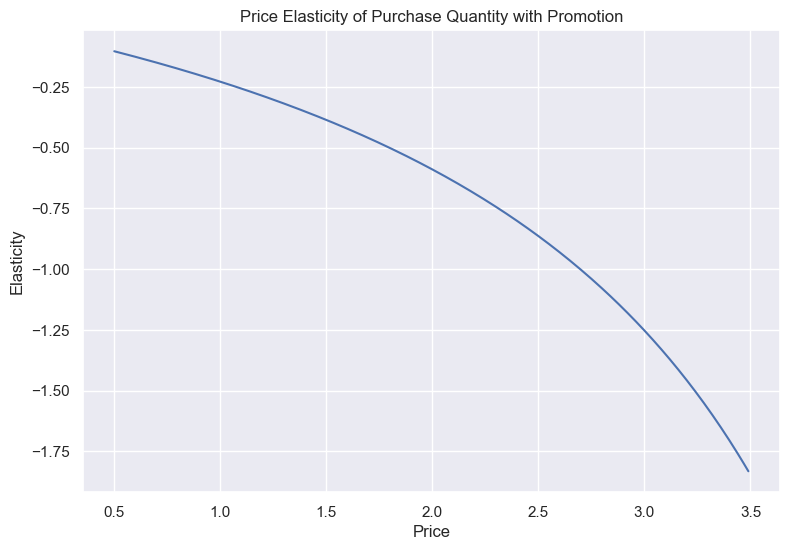

In [106]:
plt.figure(figsize = (9, 6))
plt.plot(price_range, price_elasticity_quantity_promotion_yes)
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Purchase Quantity with Promotion')

## Price Elasticity without Promotion

In [107]:
# Overwrite promotion incidence in order to use the same df. 
# Here I assume there are no promotinal activities active for the entire price range.
df_price_elasticity_quantity['Promotion_Incidence'] = 0
# Find the new predicted quantities.
predict_quantity = model_quantity.predict(df_price_elasticity_quantity)
# Calculate the new price elasticities.
price_elasticity_quantity_promotion_no = beta_quantity * price_range / predict_quantity
# Add the results to the master data frame.
df_price_elasticities['PE_Quantity_Promotion_0'] = price_elasticity_quantity_promotion_no
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3,Brand_5,Brand_5_Cross_Brand_4,Brand 5 S3,Brand_5_Cross_Brand_4_S3,Brand 5 S0,Brand_5_Cross_Brand_4_S0,Brand 5 S1,Brand_5_Cross_Brand_4_S1,Brand 5 S2,Brand_5_Cross_Brand_4_S2,PE_Quantity_Promotion_1,PE_Quantity_Promotion_0
0,0.50,-0.096346,-0.211223,-0.119071,-0.030916,-0.168003,-0.049055,0.332011,-0.297342,0.482421,-0.115834,0.174120,-0.043941,0.194769,-0.001036,0.181595,-0.102157,-0.099543
1,0.51,-0.100412,-0.217794,-0.123252,-0.032682,-0.172927,-0.050616,0.337287,-0.303389,0.491727,-0.118873,0.176176,-0.045028,0.197253,-0.001098,0.183892,-0.104413,-0.101736
2,0.52,-0.104605,-0.224472,-0.127527,-0.034536,-0.177921,-0.052207,0.342507,-0.309445,0.501016,-0.121947,0.178180,-0.046124,0.199685,-0.001163,0.186141,-0.106679,-0.103939
3,0.53,-0.108927,-0.231260,-0.131897,-0.036480,-0.182985,-0.053827,0.347668,-0.315513,0.510290,-0.125056,0.180134,-0.047230,0.202068,-0.001231,0.188340,-0.108954,-0.106150
4,0.54,-0.113383,-0.238156,-0.136363,-0.038519,-0.188121,-0.055477,0.352773,-0.321591,0.519548,-0.128201,0.182037,-0.048345,0.204400,-0.001303,0.190491,-0.111238,-0.108369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,3.45,-8.011979,-5.050960,-5.678491,-12.541303,-4.021968,-3.231572,0.162233,-3.337310,0.157503,-3.592456,0.024052,-1.287427,0.068594,-3.746081,0.023408,-1.774292,-1.664290
296,3.46,-8.037228,-5.067813,-5.698643,-12.578219,-4.036836,-3.247766,0.160333,-3.350640,0.152081,-3.606361,0.023696,-1.297236,0.067971,-3.757523,0.022948,-1.788634,-1.677205
297,3.47,-8.062442,-5.084648,-5.718759,-12.615118,-4.051687,-3.263928,0.158447,-3.363967,0.146824,-3.620221,0.023344,-1.307101,0.067352,-3.768945,0.022495,-1.803124,-1.690246
298,3.48,-8.087623,-5.101465,-5.738839,-12.652000,-4.066523,-3.280058,0.156576,-3.377291,0.141728,-3.634037,0.022997,-1.317020,0.066738,-3.780347,0.022050,-1.817766,-1.703414


Text(0.5, 1.0, 'Price Elasticity of Purchase Quantity with Promotion')

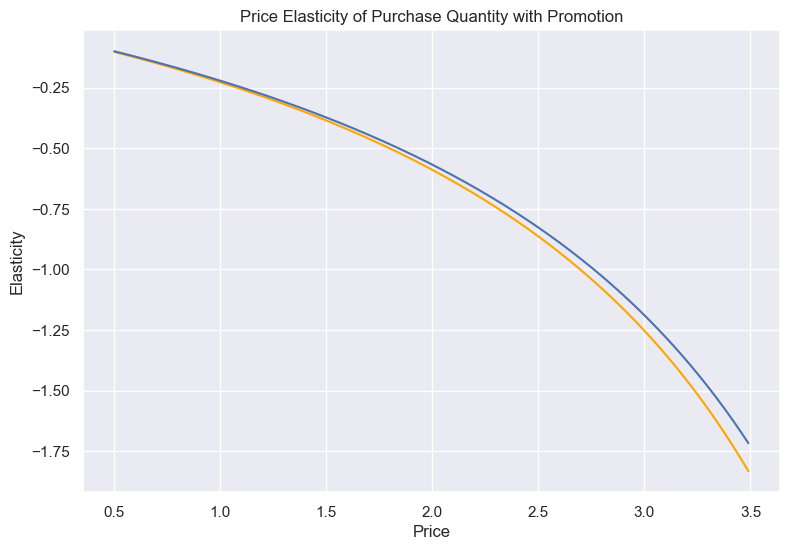

In [108]:
# Plot the two elasticities side by side. 
plt.figure(figsize = (9, 6))
plt.plot(price_range, price_elasticity_quantity_promotion_yes, color = 'orange')
plt.plot(price_range, price_elasticity_quantity_promotion_no)
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Purchase Quantity with Promotion')

In [109]:
# We observe that the two elasticities are very close together for almost the entire price range.
# It appears that promotion does not appear to be a significant factor in the customers' decission 
# what quantity of chocolate candy bars to purchase.